# Q. Black-box adversarial attack

This task is similar to the previous white box adversarial attack, but here we don't have direct access to gradient, so we need to somehow estimate it using only output of the classifier. 

There are a few different approaches to do it:
- Use *substitute network* - new model that is trained to give the same answers as black-box model. And then hope that it's gradients are similar to the gradients of original model.
- Use *finite difference method* to estimate gradient, while being precise it requires as much model evaluations
as the dimensions of input image. We have 32x32x3 input image, so there will be 3072 evaluations per iteration. It
actually may be acceptable, but we'll use another method.
- *Natural Evolution Strategies (NES)*. This method is well described in the [Black-box Adversarial Attacks with Limited Queries and Information](https://arxiv.org/abs/1804.08598) paper. In short we choose $n$ points in the neighborhood of $x$ and estimate gradient using function values at those points using formula:
$$
\nabla \mathbf{E}[F(x)] \approx \frac{1}{\sigma n}\sum_{i=1}^{n}\delta_i F(x+\sigma\delta_i)
$$
Here we don't depend on size of the input image and we can choose $n$ (number of model evaluations) to be 50 or 100. Then using the estimated gradient we iteratively update image using SGD as in white-box setting.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from input.q_bundle.interface import BlackBox

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
bbox = BlackBox()

Let's look at input image

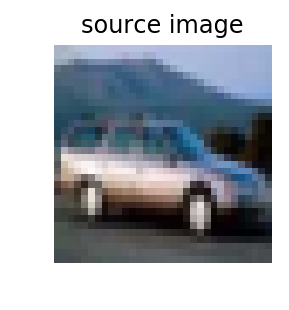

In [15]:
im = bbox.get_image()
plt.figure(figsize=(2,2))
plt.imshow(im.reshape(32, 32, -1))
plt.axis('off')
plt.title(f'source image');

Initially we have low probability of target class

In [29]:
bbox.calc(i)

0.0037834700307858779

In [18]:
def estimate_grad_nes(x, n, sigma):
    g = np.zeros_like(x).astype(float)
    for i in range(n):
        dx = np.random.normal(0, 1, x.shape)
        g += (1 - bbox.calc(x + sigma * dx)) * dx
        g -= (1 - bbox.calc(x - sigma * dx)) * dx
    
    return g / 2 / n / sigma

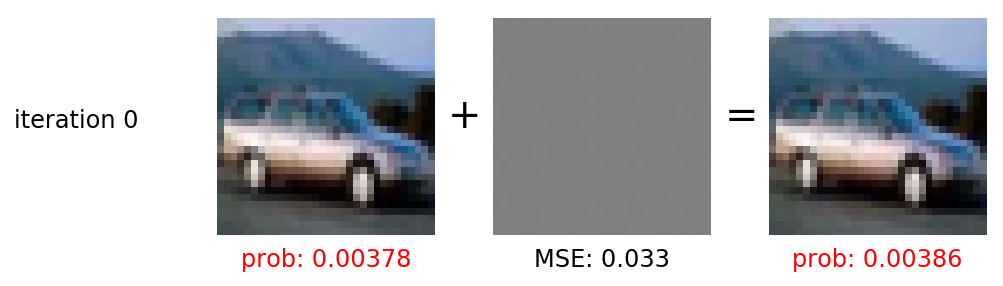

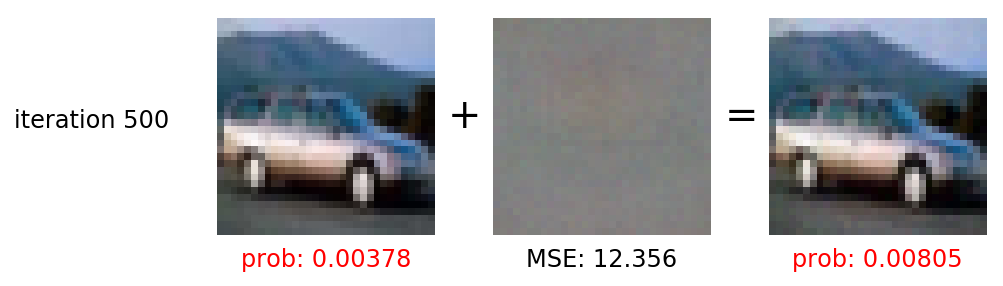

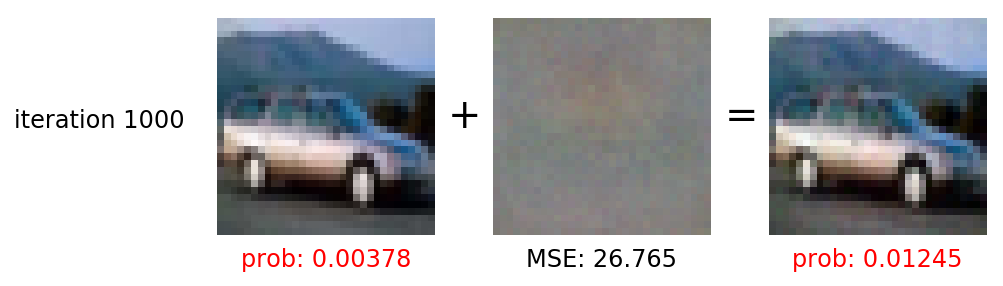

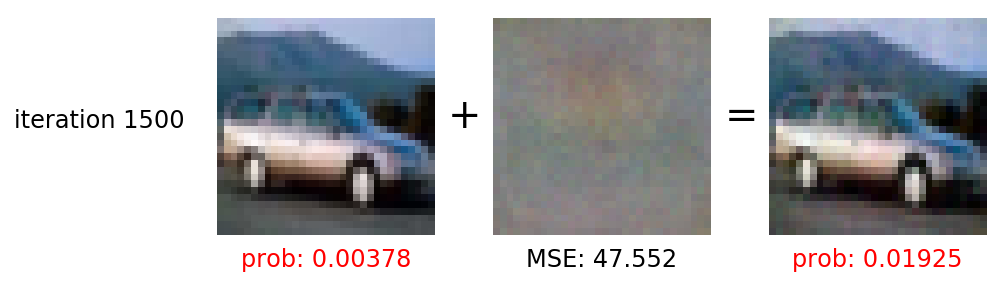

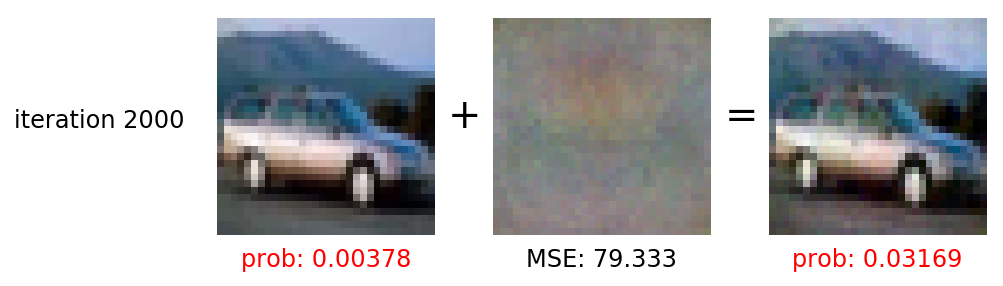

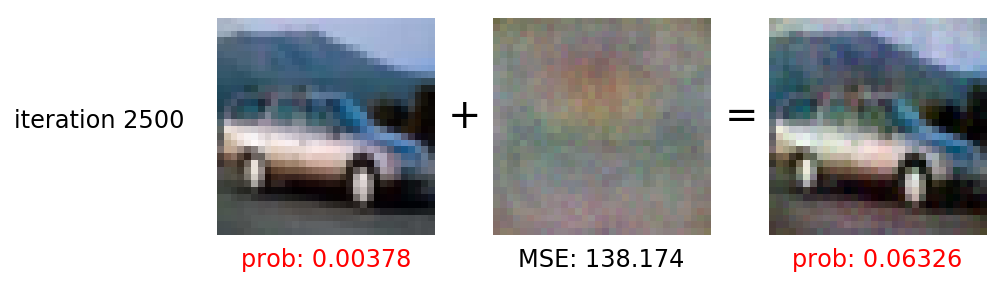

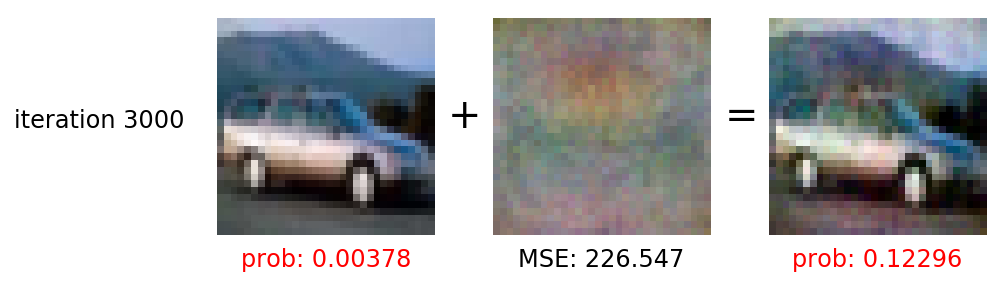

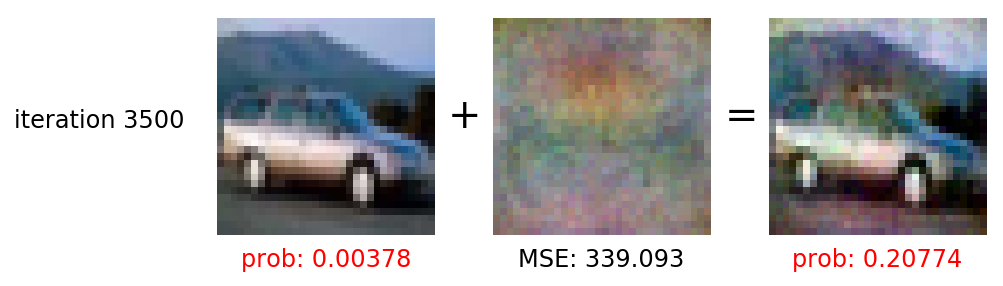

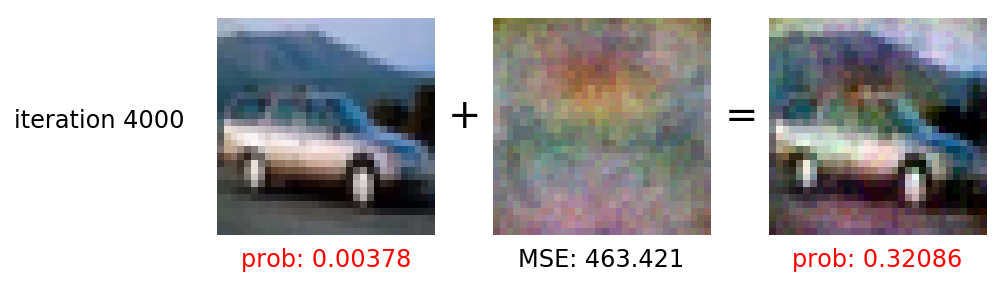

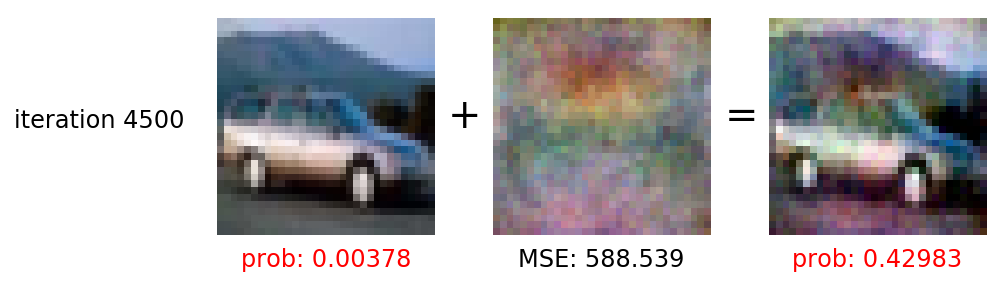

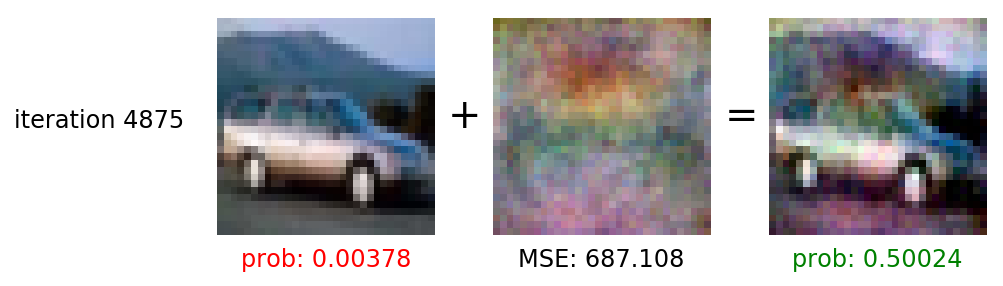

CPU times: user 2min 11s, sys: 18.8 s, total: 2min 30s
Wall time: 2min 30s


In [93]:
%%time

sigma = 0.1
n_estimate = 50
n_iter = 10000
lr = 10
l2_reg = 0.0005

x = im.astype(float)
original = x.copy()
for i in range(n_iter):
    grad = estimate_grad_nes(x, n_estimate, sigma)
    grad += l2_reg * (x - original) / x.shape[0]
    x -= lr * grad / np.linalg.norm(grad)
    x = np.clip(x, 0, 255)
    p = bbox.calc(x)
    if p > 0.5 or i % 500 == 0:
        plt.figure(figsize=(7, 2))
        plt.subplot(131)
        plt.imshow(original.astype('uint8').reshape(32, 32, -1))
        plt.axis('off')
        plt.title(f'prob: {bbox.calc(original):.5f}', y=-0.2, fontdict={'color': 'r'})
        plt.subplot(132)
        plt.imshow((x - original + 128).astype('uint8').reshape(32, 32, -1))
        plt.axis('off')
        plt.title(f'MSE: {((x - original) ** 2).mean():.3f}', y=-0.2)
        plt.subplot(133)
        plt.imshow(x.astype('uint8').reshape(32, 32, -1))
        plt.axis('off')
        plt.title(f'prob: {p:.5f}', y=-0.2, fontdict={'color': 'r' if p <= 0.5 else 'g' })
        plt.figtext(-0.07, .5, f'iteration {i}', fontsize=12)
        plt.figtext(0.36, .5, '+', fontsize=20)
        plt.figtext(0.635, .5, '=', fontsize=20)
        plt.show()
        if p > 0.5:
            break

Okay, after roughly 5000 iterations we've got desired target class probability > 0.5. It look like the MSE=687 is quite high (much larger than 235 which is the threshold to get max points for this task) and the image is distorted quite a lot. After spending some time figuring out what's wrong and how it is possible to approach much lower threshold, I submitted this solution and got good results. As it turned out there was only one test for this task and the input image in it required less distortions to fool the classifier, so it worked well. After tuning learning rate, regularization parameter and number of points for NES the desired threshold was reached.